# Атака на линейную модель

В этой блокнотебудет показана простейшая атака на линейную модель бинарной классификации


В примере будет использоваться датасет `MNIST` содержащий рукописные цифры. Постараемся отличить 3 от 7..

Возьмем обучающую выборку $(x_1, y_1), \cdots, (x_n, y_n)$ с $x_i \in \mathbb{R}^{p}$ and $y_i = \pm 1$, линейная модель строит функцию принятия решения на основе гиперплоскости:

$$ y = \text{sign}(w^{\top}x + b) \enspace, $$

где $w \in \mathbb{R}^p$ и $b\in \mathbb{R}$. 

В примере будет использована логичтическая регрессия


<img src="
https://pierreablingithub.files.wordpress.com/2019/04/fig.png" align="center" hspace="10px" vspace="0px">


## Подготовка данных

In [1]:
# импорт библиотек
import numpy as np

import matplotlib.pyplot as plt

from sklearn.datasets import fetch_openml
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

### Берем датасет `MNIST`

In [2]:
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)

## Нас итересуют только выборки, содержащие 3 или 7:

In [3]:
idxs = (y == '3') | (y == '7')
y = y[idxs]
X = X[idxs]

### Разделим набор данных на обучающий или тестовый

In [4]:
random_state = np.random.RandomState(0)



X_train, X_test, y_train, y_test = \
  train_test_split(X, y, train_size=12000, test_size=2000,
                   random_state=random_state)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Подгонка модели

Применим логистическую регрессию к обучающим данным

In [5]:
logreg = LogisticRegression(solver='lbfgs', max_iter=1000)
logreg.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

Вычислим  оценку предсказания по тестовым данным

In [6]:
print('test score = {}'.format(logreg.score(X_test, y_test)))

test score = 0.9855


Это очень высокий показатель, очевидно, что гиперплоскость хорошо разделяет два класса.

## Атака

Возьмем обучающую выборку для x

In [7]:
x = X_train[0]

In [8]:
def show(x):
    plt.title('Предсказание: %s. Уверенность: %d %%' %
              (logreg.predict([x])[0],
               100 * logreg.predict_proba([x]).max()),
              fontsize=18)
    plt.imshow(scaler.inverse_transform(x).reshape(28, 28),
               cmap=plt.cm.gray_r, vmin=0, vmax=255)
    plt.axis('off')

ValueError: ignored

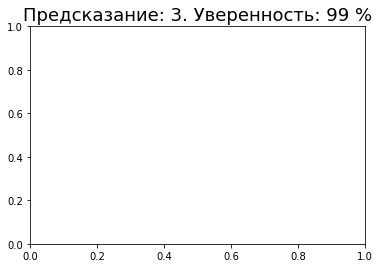

In [9]:
show(x)

Алгоритм уверен, что это 7

Возмьем некоторый `x`, переместим его в гиперплоскости выполнив:

$$ x_1 =  x - \frac{w^{\top}x + b}{w^{\top}w}w$$ 


In [ ]:
w = logreg.coef_[0]
b = logreg.intercept_

x1 = x - (np.dot(w, x) + b) / np.dot(w, w) * w

При этом алгоритм с равной вероятностью предсказывает два класса:

In [ ]:
logreg.predict_proba([x1])

Как выглядит новый x?

In [ ]:
show(x1)

Все еще выглядит как 7 !

Переместим x на другую сторону гиперплоскости:

$$ x_2 =  x - \alpha \frac{w^{\top}x + b}{w^{\top}w}w \enspace, $$ 
где $\alpha > 1$:

In [ ]:
perturbation = 1.3 * (np.dot(w, x) + b) / np.dot(w, w) * w
x2 = x - perturbation

In [ ]:
logreg.predict_proba([x2])

Теперь алгоритм уверен, что это 3!

In [ ]:
show(x2)

Для человека она по-прежнему выглядит как 7. Это то, что называется атаки на классификатор: небольшое возмущение x полностью сбивает алгоритм классификации с толку.

In [ ]:
np.linalg.norm(perturbation) / np.linalg.norm(x)

<img src="
https://pierreablingithub.files.wordpress.com/2019/04/fig2.png" align="center" hspace="10px" vspace="0px">

Суть состязательной атаки заключается в том, что даже если $x_2$ принадлежит "другой стороне" гиперплоскости, он все равно является "7" согласно нашему собственному человеческому классификатору.